In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

✅ Static Terrain Loaded. Shape: (211, 470, 4)
   Channels: Elevation, Slope, Aspect(Sin), Aspect(Cos)
✅ Found 3782 daily weather grids.
✅ Found 3819 daily target maps.

🔎 Inspecting Data for Date: 2018-12-12


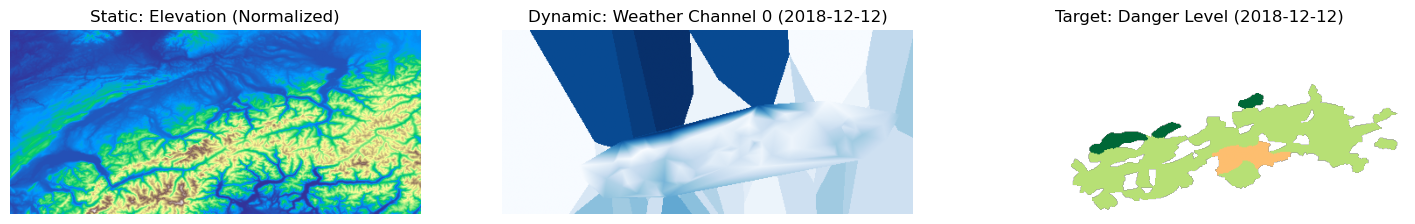

In [21]:
# --- CONFIGURATION ---
GRID_DIR = '../data/grids'
STATIC_PATH = os.path.join(GRID_DIR, 'static_terrain.npy')
DYNAMIC_DIR = os.path.join(GRID_DIR, 'dynamic')
TARGET_DIR = os.path.join(GRID_DIR, 'targets')

# --- 1. CHECK STATIC TERRAIN ---
if not os.path.exists(STATIC_PATH):
    print(f"❌ CRITICAL: Static terrain file not found at {STATIC_PATH}")
else:
    static_data = np.load(STATIC_PATH)
    print(f"✅ Static Terrain Loaded. Shape: {static_data.shape}")
    print(f"   Channels: Elevation, Slope, Aspect(Sin), Aspect(Cos)")

# --- 2. CHECK FILE COUNTS ---
dynamic_files = sorted([f for f in os.listdir(DYNAMIC_DIR) if f.endswith('.npz')])
target_files = sorted([f for f in os.listdir(TARGET_DIR) if f.endswith('.npy')])

print(f"✅ Found {len(dynamic_files)} daily weather grids.")
print(f"✅ Found {len(target_files)} daily target maps.")

if len(dynamic_files) == 0 or len(target_files) == 0:
    raise ValueError("❌ Missing dynamic or target files! Did the scripts run?")

# --- 3. VISUAL ALIGNMENT CHECK (THE MOST IMPORTANT PART) ---
# Pick a random date that exists in both sets
common_dates = list(set([f.split('.')[0] for f in dynamic_files]) & 
                    set([f.split('.')[0] for f in target_files]))
test_date = "2018-12-12"
print(f"\n🔎 Inspecting Data for Date: {test_date}")

# Load Data
weather_data = np.load(os.path.join(DYNAMIC_DIR, f"{test_date}.npz"))['data']
target_data = np.load(os.path.join(TARGET_DIR, f"{test_date}.npy"))

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Static Elevation (Background)
# We use origin='lower' because we confirmed your arrays are South-Up (Index 0 = South)
axs[0].imshow(static_data[:, :, 0], cmap='terrain', origin='lower')
axs[0].set_title("Static: Elevation (Normalized)")
axs[0].axis('off')

# Plot 2: Dynamic Feature (e.g., Channel 0 = HN72_24 / 3-Day Snow)
# Check your DYNAMIC_FEATURES list to know which index is which. Usually 0 is snow.
# Use a masked array to hide 0s if you want to see the shape better
axs[1].imshow(weather_data[:, :, 0], cmap='Blues', origin='lower') 
axs[1].set_title(f"Dynamic: Weather Channel 0 ({test_date})")
axs[1].axis('off')

# Plot 3: Target Labels (Danger Level)
# Mask out the -1 values (No Data / Borders) so they don't mess up the colors
masked_target = np.ma.masked_where(target_data < 0, target_data)
axs[2].imshow(masked_target, cmap='RdYlGn_r', origin='lower', vmin=1, vmax=4)
axs[2].set_title(f"Target: Danger Level ({test_date})")
axs[2].axis('off')

plt.show()

In [22]:
df = pd.read_parquet('../data/cleaned_data.parquet')
df['station_code'].unique()

array(['ALB2', 'ALI2', 'AMD2', 'ANV2', 'ANV3', 'ARO2', 'ARO3', 'ATT2',
       'AUE2', 'BED2', 'BED3', 'BEL2', 'BER2', 'BER3', 'BEV2', 'BIN2',
       'BOG2', 'BOR2', 'BOV2', 'CAM2', 'CAM3', 'CHA2', 'CMA2', 'CON2',
       'DAV2', 'DAV3', 'DAV4', 'DAV5', 'DIA2', 'DTR2', 'EGH2', 'ELA2',
       'ELM2', 'ELS2', 'ENG2', 'FAE2', 'FIR2', 'FIS2', 'FLU2', 'FNH2',
       'FOU2', 'FRA2', 'FRA3', 'FUL2', 'FUS2', 'GAD2', 'GAN2', 'GLA2',
       'GOM2', 'GOM3', 'GOR2', 'GRA2', 'GUG2', 'GUT2', 'GUT3', 'HTR2',
       'HTR3', 'ILI2', 'JAU2', 'JUL2', 'KES2', 'KLO2', 'KLO3', 'LAG2',
       'LAG3', 'LAU2', 'LHO2', 'LUK2', 'LUM2', 'MAE2', 'MEI2', 'MES2',
       'MLB2', 'MTR2', 'MUN2', 'MUO2', 'MUT2', 'NAR2', 'NAS2', 'NEN2',
       'NEN3', 'OBM2', 'OBW2', 'OBW3', 'OFE2', 'ORT2', 'OTT2', 'PAR2',
       'PMA2', 'PUZ2', 'RNZ2', 'ROA2', 'ROA4', 'ROT2', 'ROT3', 'SAA2',
       'SAA3', 'SAA4', 'SAA5', 'SCA2', 'SCA3', 'SCB2', 'SCH2', 'SHE2',
       'SIM2', 'SLF2', 'SMN2', 'SPN2', 'SPN3', 'STH2', 'STN2', 'TAM2',
      

In [23]:
import pandas as pd
import numpy as np
import os

# Configuration
STATION_CODE = 'JUL2'  # Weissfluhjoch (Reference Station)
TEST_DATE = '2019-01-14' # A day with known good data
DYNAMIC_DIR = '../data/grids/dynamic'
CLEANED_DATA_PATH = '../data/cleaned_data.parquet'
GRID_META_PATH = '../data/grids/grid_metadata.npz'
DYNAMIC_FEATURES = [
    # --- 1. The "Super Predictors" (Top Correlations) ---
    'delta_elevation',    # Rank #2 (r=-0.601). Critical context.
    'Pen_depth',          # Rank #3 (r=+0.581). Best proxy for "unstable new snow".
    'HN72_24',            # Rank #4 (r=+0.543). Best measure of cumulative loading.

    # --- 2. The "Driver" Group (Weather) ---
    'TA',                 # Rank #7 (r=-0.420). Temperature is the main "state" variable.
    'wind_trans24',       # Rank #8-ish. Captures the "loading" effect better than raw wind.
    'RH',                 # Rank #13 (r=+0.360). Proxy for storm presence.

    # --- 3. The "Stability" Group (Snowpack Structure) ---
    # We chose min_ccl_pen over Sn because your EDA showed it has higher correlation
    # (r=-0.374 vs r=-0.292).
    'min_ccl_pen',        

    # --- 4. The "Engineered" Context ---
    'relative_load_3d',   # You proved this had strong correlation (+0.410) in feature engineering.
    
    # --- 5. Raw Wind (Required for CNN Spatial Learning) ---
    # Even though raw 'VW' had lower correlation, the CNN NEEDS vectors to learn 
    # "Lee Slope Loading" patterns spatially.
    # Note: The script adds 'wind_u' and 'wind_v' automatically from VW/DW.
    'VW', 'DW' 
]

# 1. Get Ground Truth (Tabular)
df = pd.read_parquet(CLEANED_DATA_PATH)
truth_row = df[(df['station_code'] == STATION_CODE) & (df['datum'] == TEST_DATE)].iloc[0]
station_lat = truth_row['lat']
station_lon = truth_row['lon']

# 2. Find Grid Indices for this Station
grid_meta = np.load(GRID_META_PATH)
lats = grid_meta['lats']
lons = grid_meta['lons']

# Find nearest pixel index (argmin of difference)
lat_idx = (np.abs(lats - station_lat)).argmin()
lon_idx = (np.abs(lons - station_lon)).argmin()

print(f"Station {STATION_CODE} is at Lat: {station_lat:.4f}, Lon: {station_lon:.4f}")
print(f"Mapped to Grid Pixel: Row {lat_idx}, Col {lon_idx}")

# 3. Load the Grid
grid_path = os.path.join(DYNAMIC_DIR, f"{TEST_DATE}.npz")
grid_data = np.load(grid_path)['data'] # Shape (H, W, Channels)

# 4. Compare Values
print(f"\n{'Feature':<20} | {'Original (CSV)':<15} | {'Grid Pixel':<15} | {'Difference'}")
print("-" * 65)

for i, feature in enumerate(DYNAMIC_FEATURES):
    original_val = truth_row[feature]
    grid_val = grid_data[lat_idx, lon_idx, i]
    diff = abs(original_val - grid_val)
    
    status = "✅" if diff < 0.01 else "❌"
    print(f"{feature:<20} | {original_val:<15.4f} | {grid_val:<15.4f} | {diff:.4f} {status}")

Station JUL2 is at Lat: 46.4785, Lon: 9.6923
Mapped to Grid Pixel: Row 68, Col 379

Feature              | Original (CSV)  | Grid Pixel      | Difference
-----------------------------------------------------------------
delta_elevation      | 400.0000        | 399.9854        | 0.0146 ❌
Pen_depth            | 28.6357         | 28.5822         | 0.0535 ❌
HN72_24              | 61.1352         | 61.3870         | 0.2517 ❌
TA                   | -10.4625        | -10.4534        | 0.0091 ✅
wind_trans24         | 2.5938          | 2.6406          | 0.0468 ❌
RH                   | 84.3375         | 84.5645         | 0.2270 ❌
min_ccl_pen          | 0.2400          | 0.2397          | 0.0003 ✅
relative_load_3d     | 0.3401          | 0.3415          | 0.0015 ✅
VW                   | 2.0375          | 2.0439          | 0.0064 ✅
DW                   | 123.0000        | 123.1269        | 0.1269 ❌


In [31]:
import numpy as np
import os

# 1. Pick a file to inspect
output_dir = '../data/grids/dynamic'
sample_file = os.listdir(output_dir)[0] # Get the first file found
file_path = os.path.join(output_dir, sample_file)

# 2. Load the file
print(f"Inspecting: {sample_file}")
with np.load(file_path) as data:
    # List all internal arrays (should just be 'data')
    print(f"Keys in file: {list(data.keys())}")
    
    # Get the main array
    grid = data['data']
    
    # 3. Check Dimensions
    print(f"Grid Shape: {grid.shape}")
    # Expected: (Height, Width, Channels) e.g., (180, 370, 11)
    
    channels = grid.shape[-1]
    print(f"Number of Channels: {channels}")

# 4. Verify Mapping against your List
# COPY this list exactly from your '2_daily_grids.py' script to verify
EXPECTED_FEATURES = dynamic_features = [
        'delta_elevation',   
        'Pen_depth',          
        'HN24',              # Daily snowfall
        'MS_Snow',           
        'TA',                 
        'wind_trans24',       
        'RH',             
        'min_ccl_pen',        
        'relative_load_3d',
        'wind_u',  # Zonal Velocity
        'wind_v'   # Meridional Velocity   
    ]

if channels == len(EXPECTED_FEATURES):
    print("✅ Channel count matches your feature list!")
    for i, feat in enumerate(EXPECTED_FEATURES):
        print(f"  Channel {i}: {feat}")
else:
    print(f"❌ MISMATCH: File has {channels} channels, but list has {len(EXPECTED_FEATURES)}")

Inspecting: 1997-11-12.npz
Keys in file: ['data']
Grid Shape: (211, 470, 11)
Number of Channels: 11
✅ Channel count matches your feature list!
  Channel 0: delta_elevation
  Channel 1: Pen_depth
  Channel 2: HN24
  Channel 3: MS_Snow
  Channel 4: TA
  Channel 5: wind_trans24
  Channel 6: RH
  Channel 7: min_ccl_pen
  Channel 8: relative_load_3d
  Channel 9: wind_u
  Channel 10: wind_v
